In [3]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools

# data and statistics libraries
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [10,6]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [4]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


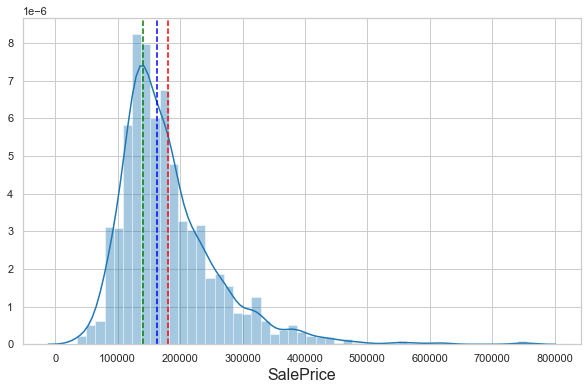

In [5]:
sigma = train_df.SalePrice.std()
mu = train_df.SalePrice.mean()
med = train_df.SalePrice.median()
mode = train_df.SalePrice.mode().to_numpy()

sns.distplot(train_df.SalePrice)
plt.axvline(mode, linestyle='--', color='green')
plt.axvline(med, linestyle='--', color='blue')
plt.axvline(mu, linestyle='--', color='red')

Our response variable appears to be right skewed, so is a candidate for log transformation. Below we see that log(y+1) provides a nice distribution. We will keep this distribution in mind for use in a `TransformedTargetRegressor` when it is time to make predictions.

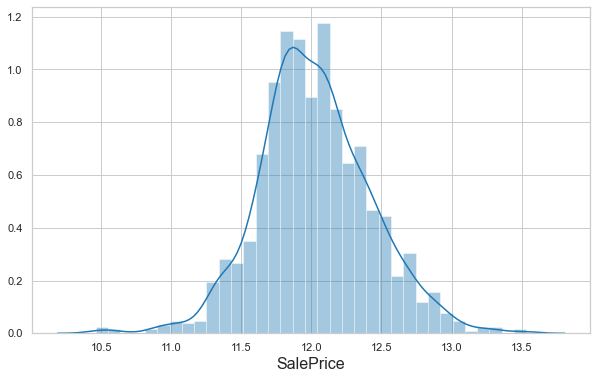

In [6]:
sns.distplot(np.log1p(train_df.SalePrice), kde=True)

Let's get warmed up with a check our intuition that it's not just quantity but quality that counts toward final sale price:

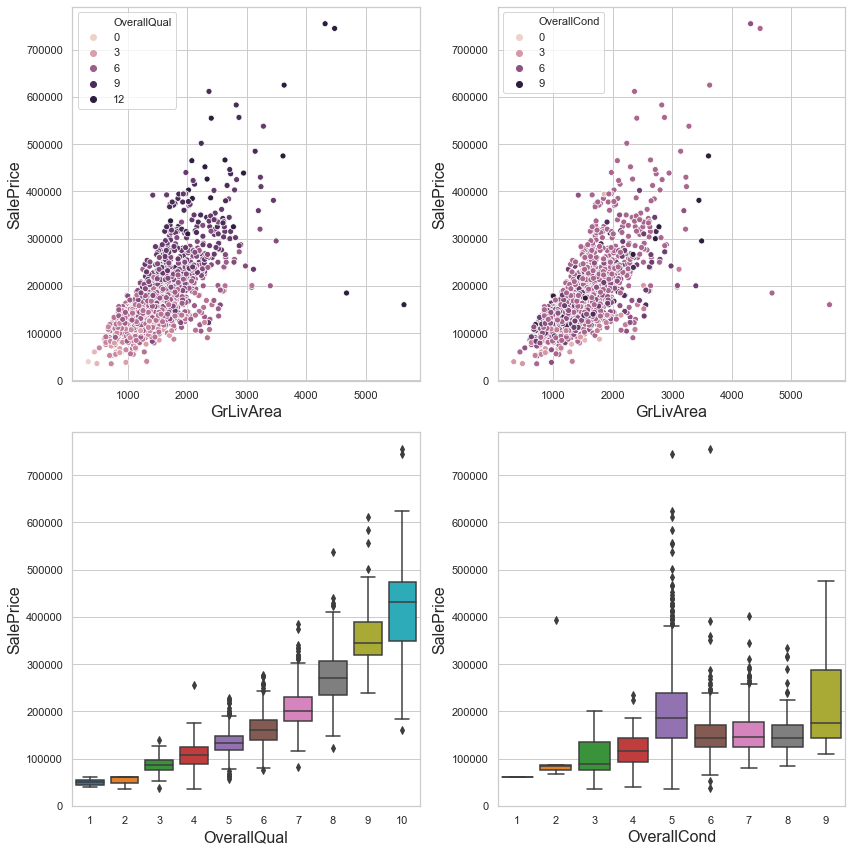

In [7]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=train_df, ax=axes[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallCond', data=train_df, ax=axes[0,1])
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, ax=axes[1,0])
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, ax=axes[1,1])
plt.tight_layout()

It appears that sale price is graduated not only by above ground living area but also by quality of material and finish (described by __OverallQual__). Surprisingly, it appears that overall condition (__OverallCond__) is rather well mixed. The box plots show negative skew (towards smaller area) in below average condition homes and positive skew (towards larger) in above average condition homes, but nothing to write home about. 

Also notice the two outliers, homes with relatively large square footage, plus high quality materials, above average condition which sold ___well___ below average. We will likely discount these outliers for purposes of making predictions.

Next we will run through some of the other most intuitive predictors of home sale prices, looking for correlation to our response variable (sale price). We will use both standard univariate correlation now, and later post-hoc residual plots to test our assumptions of linearity. In order to perform statistical modeling, we need to convert our categorical data to numbers first. The variables I believe intuitively add to sale prices are:

In [8]:
# a selection of variables that I expect to add to home value and/or curbside appeal, by variable type
exp_ordinal = ['ExterQual', 'ExterCond', 'Functional', 'OverallQual', 'OverallCond', 'BsmtCond']
exp_nominal = ['Neighborhood', 'MSZoning', 'Condition1', 'Condition2']
exp_contin  = ['LotArea', 'GrLivArea', 'GarageArea']

Almost all "Quality and Condition" variables share the same letter code scheme in the data: 

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Some variables like __BsmtCond__ (Basement Condition) have an additional category (NA - No Basement). We will encode these as integers from 0 to 5.

In [9]:
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 
             'BsmtCond', 'HeatingQC', 'KitchenQual', 
             'FireplaceQu', 'GarageQual', 'GarageCond',
             'PoolQC']

for col in qual_vars:
    train_df[col] = train_df[col].map(qual_map)
    
train_df[qual_vars]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4.0,3.0,5,4,NaN,3.0,3.0,NaN
2,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
3,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
4,3,3,3.0,4.0,4,4,4.0,3.0,3.0,NaN
5,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1456,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
1457,3,3,4.0,3.0,3,3,3.0,3.0,3.0,NaN
1458,5,4,3.0,4.0,5,4,4.0,3.0,3.0,NaN


The __Functional__ variable, which outlines major deductions or damage might be good to inspect, so we will encode it as a ordinal variable.

In [10]:
func_map = {
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}

train_df['Functional'] = train_df.Functional.map(func_map)

Next, we will encode the nominal variables we wish to inspect:

In [11]:
train_df[exp_nominal]

,Neighborhood,MSZoning,Condition1,Condition2
Id,,,,
1,CollgCr,RL,Norm,Norm
2,Veenker,RL,Feedr,Norm
3,CollgCr,RL,Norm,Norm
4,Crawfor,RL,Norm,Norm
5,NoRidge,RL,Norm,Norm
...,...,...,...,...
1456,Gilbert,RL,Norm,Norm
1457,NWAmes,RL,Norm,Norm
1458,Crawfor,RL,Norm,Norm


In [12]:
# for var in exp_nominal:
#     train_df[var], _ = pd.factorize(train_df[var])

Now, we must consider the association between our predictor variables and our response variable. Because we are dealing with a continuous response variable, but have some categorical features, we will have to think carefully about how to measure association. For the ordinal data, I propose either using Kendall's $\tau$ or descritizing sale prices and using Goodman and Kruskal's $\gamma$. Since Kendall's $\tau$ is included in the scikit learn library, we need not write our own method. 

In [13]:
exp_ordinal.append('SalePrice'),
exp_contin.append('SalePrice')

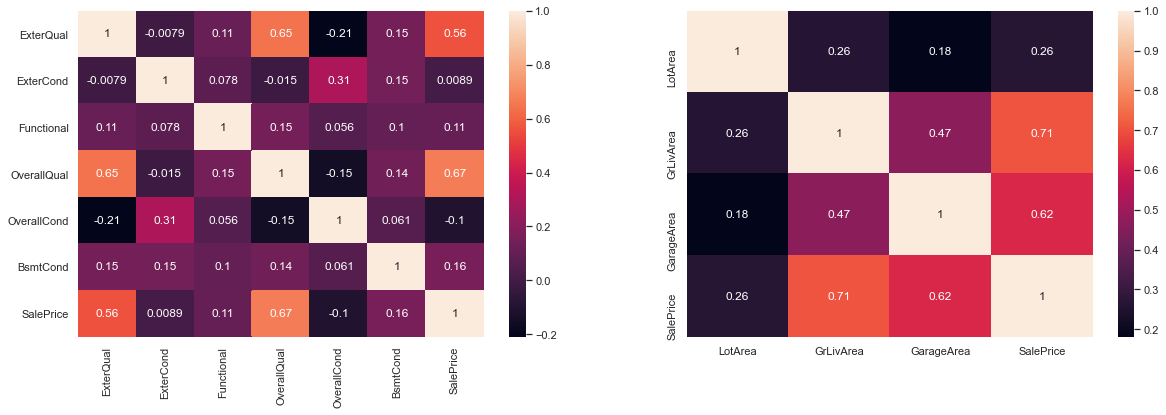

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

sns.heatmap(train_df[exp_ordinal].corr(method='kendall'), annot=True, ax=axes[0])
sns.heatmap(train_df[exp_contin].corr(), annot=True, ax=axes[1])

For our nominal data, quantitative association is somewhat difficult to achieve in the same way as ordinal and continuous data. We can, however take a look at box our violin plots for each of our interesting nominal variables. The idea is to look for separation of home values according to category. We are graphically answering questions like _"Is the average cost of a home significantly different between neighborhoods X, Y, and Z?"_.

To refresh our memories on what our nominal variables are:

- __Neighborhood__
- __MSZoning__
- __Condition1 & Condition2__


### Neighborhood:

In [67]:
# for ordering the boxplots by median
grouped = train_df.loc[:,['Neighborhood', 'SalePrice']] \
    .groupby(['Neighborhood']) \
    .mean() \
    .sort_values(by='SalePrice')

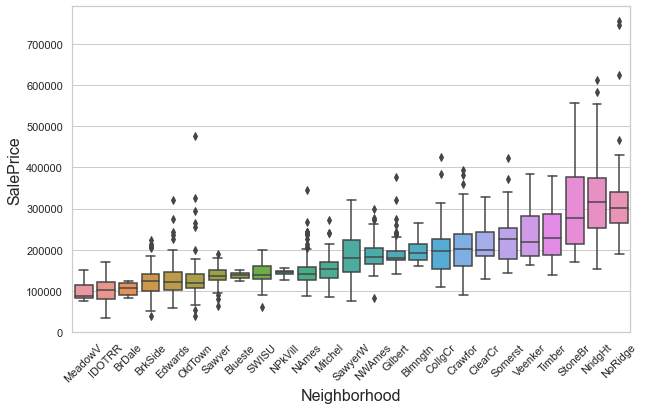

In [68]:
chart = sns.boxplot(x=train_df.Neighborhood, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

It appears that we can order neighborhoods by their median home value. It remains to be seen how much weight the adage "location, location, location" carries, but on first glance it has at least some meaning.

### Zoning

Our data dictionary defines __MSZoning__ as _"Identifies the general zoning classification of the sale."_, with the following possible categories:

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

We will apply the same techniques as before to see if we can rank these zones by their average home value.

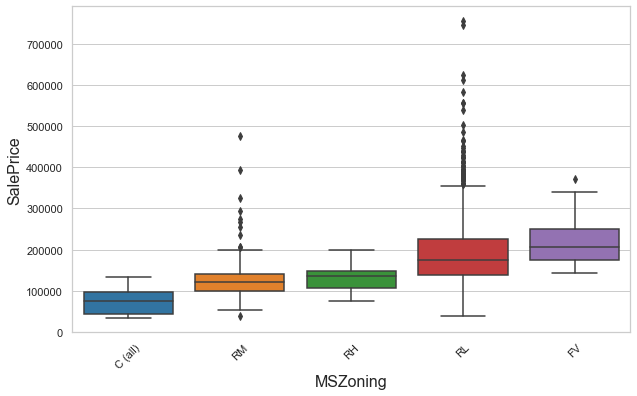

In [66]:
grouped = train_df.loc[:,['MSZoning', 'SalePrice']] \
    .groupby(['MSZoning']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.MSZoning, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

As before, there is some overlap but there appears to a general ordering involved. 

## Proximity to Urban Features

The __Condition1 & Condition2__ variables describe proximity to the following features:

       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

We will see if we can rank these features as before, but this time we will rank both individual features and every combination of two. 

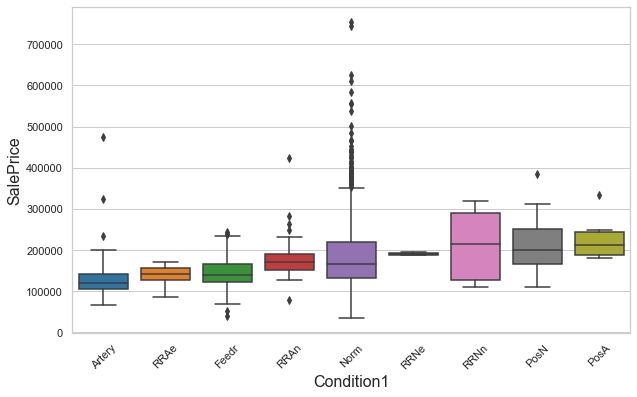

In [64]:
grouped = train_df.loc[:,['Condition1', 'SalePrice']] \
    .groupby(['Condition1']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.Condition1, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [2]:
regressor = LinearRegression()
X = train_df.loc[:,'GrLivArea'].to_numpy().reshape(-1, 1)
Y = train_df.loc[:, 'SalePrice'].to_numpy().reshape(-1, 1)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y)

regressor.fit(x_train,y_train)
pred = regressor.predict(x_test)

res = np.squeeze(pred - y_test)
partial_res = res + np.squeeze(pred)

partial_res.dtype, x_test.dtype

xi = np.squeeze(x_test)
yi = np.squeeze(y_test)
sns.scatterplot(xi, res)
sns.lineplot(x=np.linspace(0, xi.max(), len(xi)), 
             y=np.zeros(len(y_test)), 
             color='red')


NameError: name 'LinearRegression' is not defined

__FireplaceQu__ (Fireplace Quality) is the first variable with less than 50 percent missing data. The __Fireplaces__ (# of fireplaces variable)  has a possible value of "NA - No Fireplace". Perhaps these entries are associated with the missing data in the quality description.

In [4]:
nofire_na = train_df.loc[train_df.FireplaceQu.isna() &
                         (train_df.Fireplaces == 0)].shape[0]

In [5]:
train_df.FireplaceQu.isna().sum(), nofire_na

(690, 690)

So indeed, all 690 instances of missing data in __FireplaceQu__ are associated with homes that don't have fireplaces. According to the variable description, these values should be "NA" not "NaN". We will fix that now:

In [6]:
train_df.loc[train_df.FireplaceQu.isnull(), 'FireplaceQu'] = 'NA'

In [7]:
(train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending=False).head(10)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
LotFrontage     0.177397
GarageType      0.055479
GarageQual      0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64